In [586]:
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as uReq
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sb
import pandas as pd
import numpy as np
import openpyxl
import zipfile
import difflib
import re
import os

In [576]:
% matplotlib inline

In [3]:
def get_page(query):
    
    '''
    Method to read the page from an html query, and to handle connection errors.
    
    In case of a connection error, will retry every 10 seconds for five minutes.
    
    This method will abort the program if connection cannot be established after 5 minutes.
    
    Input: query (HTML query requesting a particular page)
    Output: page (HTML contents from requested page)
    '''
    
    page = ''
    
    try:
        client = uReq(query)
        page = client.read()
        client.close()
    except: # in case of connection error from uReq(query)
        retries = 0
        while(retries < 30 and len(page) == 0):
            print('Connection error... waiting 10 seconds...')
            time.sleep(10) # wait 10 seconds
            # try again
            try:
                print('Retrying...')
                client = uReq(query)
                page = client.read()
            except:
                retries += 1
        if retries >= 30 and len(page) == 0: # exit the program
            sys.exit('Cannot reach page after trying for 5 minutes.\nAborting program...')
            
    return page

In [2]:
# download zip archive containing list of accredited US Universities
source_url = 'https://ope.ed.gov/accreditation/dataFiles/Accreditation_2017_04.zip'
curr_folder = %pwd
dest_filename = curr_folder + '\Accreditation_2017_04.zip'
urlretrieve(source_url, dest_filename)

('c:\\users\\joel\\documents\\code\\Machine Learning\\Recommendation Systems\\Accreditation_2017_04.zip',
 <http.client.HTTPMessage at 0x26be58cc710>)

In [3]:
# extract contents of zip archive
filename = dest_filename.split('\\')[-1]

with zipfile.ZipFile(filename) as zf:
    zf.extractall(curr_folder)

In [4]:
# read file
accred_file = 'Accreditation_04_2017.csv'
colleges = pd.read_csv(accred_file)

# select unique college names
college_list = colleges['Institution_Name'].unique()

#### Web Scraping Module

In [ ]:
college_count = 0

book = openpyxl.Workbook()
sheet = book.get_active_sheet()
file_name = 'college_stats1.xlsx'

row_number = 1 # 1st row in excel sheet

#write header row
header = ['Institution', 'Program', 'Decision', 'Decision_medium', 'Status', 'Date', 'GPA', 'GRE_v', 'GRE_q', 'GRE_w', 'GRE_subj']
cols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
for col_index in range(len(header)):
    cell = cols[col_index] + str(row_number)
    sheet[cell].value = header[col_index]

for college in college_list:
        
    college_count += 1
    
    # create new file for query results for every 1000 colleges
    if college_count%1000 == 0:
        
        book.save(file_name) # save previous excel workbook
        book = openpyxl.Workbook() # open new workbook
        sheet = book.get_active_sheet()
        # set new filename
        file_name = 'college_stats' + str((college_count/1000) + 1) + '.xlsx'
        # reset row_number and write header line into the new file
        row_number = 1
        for col_index in range(len(header)):
            cell = cols[col_index] + str(row_number)
            sheet[cell].value = header[col_index]

    # in case of spaces in the school name, replace spaces with '%20' (to avoid http query error)
    search_query = college.replace(' ', '%20')

    # visit 1st result page for this college's query and extract total number of result pages
    # -------------------
    college_query = 'http://thegradcafe.com/survey/index.php?q=' + search_query
    page = get_page(college_query)
    page_soup = soup(page, "html.parser")

    # try to extract number of pages of results returned. If no results, move on to next college query
    try:
        pagination = page_soup.find('div', attrs = {'class': re.compile('pagination')})
        num_pages = int(pagination.text.split(' ')[4])
    except:
        print('School {}: {}... no search results.\n'.format(college_count, college))
        continue
    # -------------------

    # scrape data of interest from each result page
    print('School {}: {}'.format(college_count, college))
    print('Number of search result pages: {}'.format(num_pages))
    
    for p in range(1, num_pages + 1):
        print('Page {}...'.format(p), end = ' ')
        page_query = college_query + '&t=a&o=&p=' + str(p)
        page = get_page(page_query)
        page_soup = soup(page, "html.parser")

        # ------------------- Begin reading of relevant page content -----------------------------
        for coll in page_soup.findAll('td', attrs = {'class': re.compile('instcol')})[1:]: # skip [0]: header on each page
            items = coll.find_next_siblings()[:-1] #drop the 'Comments' column (not needed)
            items.append(coll)

            row_number += 1 # start writing data from next row
            current_row = str(row_number)

            # for each record, write Institution, Program, Decision, Decision_Medium, Status, Date, gpa, gre_v, gre_q, gre_w, gre_subj
            try:
                sheet['A' + current_row].value = items[-1].text # Institution or College Name
                sheet['B' + current_row].value = items[0].text # Program

                decision = items[1].text.split('via')
                sheet['C' + current_row].value = decision[0].strip(' ') # actual decision (accepted, rejected, wait listed, etc)
                sheet['D' + current_row].value = decision[1].strip(' ').split(' ')[0] # decision medium (via email, phone, etc)

                sheet['E' + current_row].value = items[2].text # Applicant status
                sheet['F' + current_row].value = items[3].text # Date of decision
            except:
                pass
            
            if 'Undergrad GPA' in items[1].text: # extract gpa and GRE scores
                scores = items[1].text.split('GRE')
                gpa = scores[0].split(':')[1].strip(' ')
                gre_scores = scores[1].split(':')[1].strip(' ')
                gre_v, gre_q, gre_w = gre_scores.split('/')
                gre_subj = scores[2].split(':')[1][:-1].strip(' ')

                sheet['G' + current_row].value = gpa
                sheet['H' + current_row].value = gre_v
                sheet['I' + current_row].value = gre_q
                sheet['J' + current_row].value = gre_w
                sheet['K' + current_row].value = gre_subj
            else: # move on to next line
                pass
#                 college_stats.write('\n')
        # -------------------- End reading of relevant page content -----------------------------

    print('\n')

print('{} schools processed!'.format(college_count))

book.save(file_name)

#### Read in data

In [ ]:
# current_dir = %pwd
# data_files = [file for file in os.listdir(current_dir) if file.split('_')[0] == 'college']

file1 = pd.read_excel('college_stats1.xlsx')
print('file1 read')
file2 = pd.read_excel('college_stats2.xlsx')
print('file2 read')
file3 = pd.read_excel('college_stats3.xlsx')
print('file3 read')
file4 = pd.read_excel('college_stats4.xlsx')
print('file4 read')
file5 = pd.read_excel('college_stats5.xlsx')
print('file5 read')
file6 = pd.read_excel('college_stats6.xlsx')
print('file6 read')
file7 = pd.read_excel('college_stats7.xlsx')
print('file7 read')
file8 = pd.read_excel('college_stats8.xlsx')
print('file8 read')
file9 = pd.read_excel('college_stats9.xlsx')
print('file9 read')
file10 = pd.read_excel('college_stats10.xlsx')
print('file10 read')

#### Merge and clean up data

In [377]:
# merge data
college_data = pd.concat([file1, file2, file3, file4, file5, file6, file7, file8, file9, file10], ignore_index = True)

In [378]:
# drop all rows that have no Institution name
college_data = college_data[college_data.Institution.notnull()]

In [379]:
# drop any duplicate rows
college_data = college_data.drop_duplicates()

In [380]:
# convert Date column to datetime
college_data.Date = pd.to_datetime(college_data.Date)

In [597]:
# insert a 'Year' column
college_data['Year'] = college_data.Date.dt.year

In [381]:
# remove stray website formatting strings found in 'Program' colums
prog_list = college_data.Program.values
for index in range(len(prog_list)):
    if 'Onmouseover' in prog_list[index]:
        prog_list[index] = (prog_list[index].split('"')[-1]).strip(' ')

In [382]:
# extract program, degree and semester information from prog_list
program, degree, semester = [], [], []
for item in prog_list:
    try:
        program.append(' '.join(item[:-6].split()[:-1])[:-1])
        degree.append(item[:-6].split()[-1])
        semester.append(item[-4])
    except:
        if len(degree) < len(program): # error was thrown at degree
            degree.append(np.nan)
        if len(semester) < len(degree): # error was thrown at semester
            semester.append(np.nan)

In [383]:
# insert program, degree and semester into college_data
college_data.Program = program
college_data.insert(loc = 2, column = 'Degree', value = degree)
college_data.insert(loc = 3, column = 'Semester', value = semester)

In [642]:
college_data.head()

,Institution,Program,Degree,Semester,Decision,Decision_medium,Status,Date,GPA,GRE_v,GRE_q,GRE_w,GRE_subj,Year
0,Alabama A & M University,Comunication Sciences&Disorders/Speech Languag...,Masters,F,Other,Other,A,2017-05-18,NaN,NaN,NaN,NaN,NaN,2017
1,Alabama A & M University,Communication Sciences & Disorders / Speech Pa...,Masters,F,Other,Other,A,2017-05-17,3.42,147.0,144.0,3.5,n/a,2017
2,University of Alabama at Birmingham,Health Physics,Masters,F,Interview,E-mail,A,2017-05-17,3.55,153.0,153.0,4.0,n/a,2017
3,Alabama A & M University,Communication Sciences & Disorders / Speech La...,Masters,F,Accepted,Phone,A,2017-05-17,3.42,147.0,144.0,3.5,n/a,2017
4,The University of Alabama,CDDS- Speech-Language Pathology,Masters,F,Accepted,E-mail,A,2017-05-16,NaN,NaN,NaN,NaN,NaN,2017


#### Status description:

- A: American Student
- U: International student with US degree
- I: International student without US degree

#### Plot 1: Acceptance Rate per degree by immigrant status

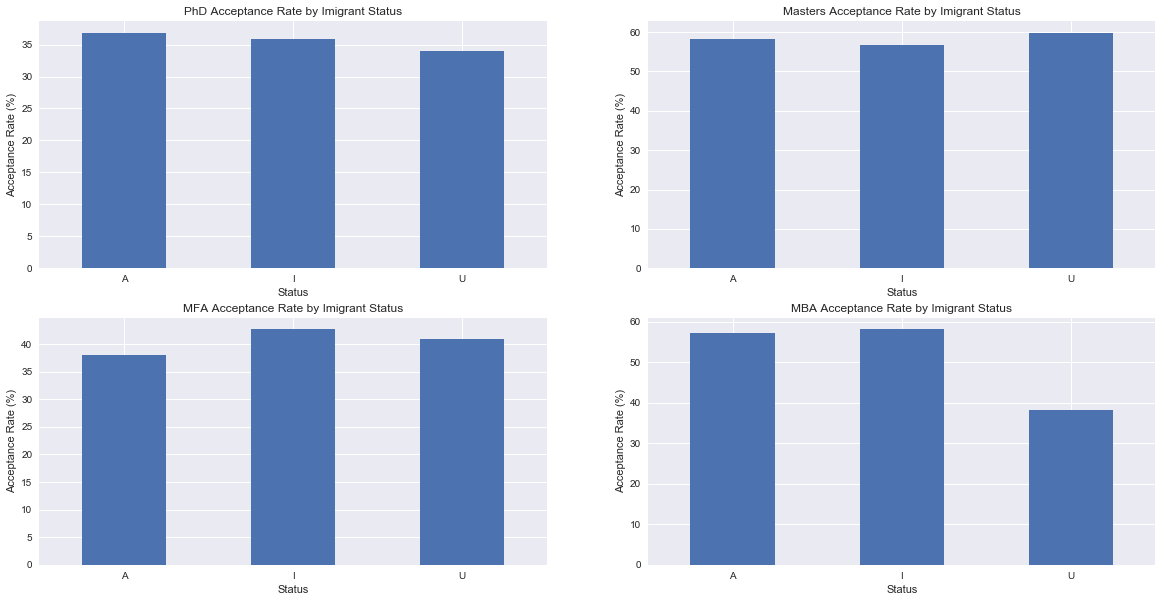

In [632]:
valid_status = college_data[college_data.Status.isin(['A', 'I', 'U'])]
accepted = valid_status[valid_status.Decision == 'Accepted']

acc_rate = 100 * accepted.Status.groupby(accepted.Degree).value_counts().div(valid_status.Status.groupby(valid_status.Degree).value_counts())

phd = acc_rate.loc['PhD']
masters = acc_rate.loc['Masters']
mfa = acc_rate.loc['MFA']
mba = acc_rate.loc['MBA']

rcParams['figure.figsize'] = (20, 10)

plt.subplot(2, 2, 1)
phd.plot(kind = 'bar')
plt.xticks(rotation='horizontal')
plt.title('PhD Acceptance Rate by Imigrant Status')
plt.ylabel('Acceptance Rate (%)')

plt.subplot(2, 2, 2)
masters.plot(kind = 'bar')
plt.xticks(rotation='horizontal')
plt.title('Masters Acceptance Rate by Imigrant Status')
plt.ylabel('Acceptance Rate (%)')

plt.subplot(2, 2, 3)
mfa.plot(kind = 'bar')
plt.xticks(rotation='horizontal')
plt.title('MFA Acceptance Rate by Imigrant Status')
plt.ylabel('Acceptance Rate (%)')

plt.subplot(2, 2, 4)
mba.plot(kind = 'bar')
plt.xticks(rotation='horizontal')
plt.title('MBA Acceptance Rate by Imigrant Status')
plt.ylabel('Acceptance Rate (%)')

# plt.legend(['A', 'I', 'U'],['American', 'Int (no US deg)', 'Int (US deg)'])

plt.show()

This is interesting, showing for example that US colleges generally tend to accept more international students for MFA and MBA programs.

However, we can drill down further into the data to gain more meaningful insights. Let us imagine an international student who wants to pursue a PhD in Biostatistics. This student scored 155 on the GRE quantitative section. Based on our data, we can present a list colleges, ranked in order of acceptance rate for international students applying for a PhD in Biostatistics.

#### Plot 2: Acceptance rates for international students applying for a PhD in Biostatistics

GRE scores were rescaled after 2011, but students were reporting on both old and new scales until 2013. We will filter our data to only include GRE scores within the new scale, and between 2013 and 2017.

In [643]:
new_gre_v = college_data[college_data.GRE_v <= 170]
new_gre_q = college_data[college_data.GRE_q <= 166]

new_gre_v = new_gre_v[new_gre_v.Year.isin([2013, 2014, 2015, 2016, 2017])]
new_gre_q = new_gre_q[new_gre_q.Year.isin([2013, 2014, 2015, 2016, 2017])]

Since we are interested in good-quality colleges, we can select colleges that accept GRE quantitative scores greater than or equal to this student's score

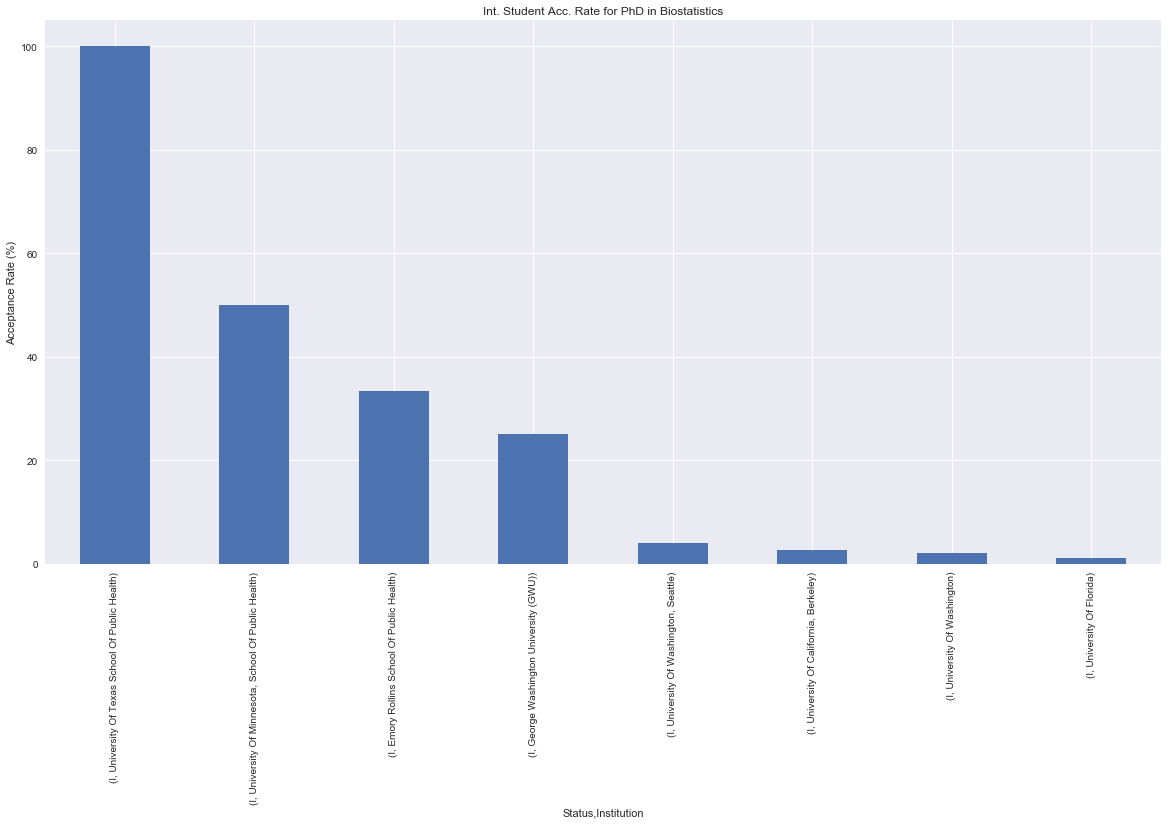

In [644]:
your_greq_score = 155
your_colleges = new_gre_q[new_gre_q.GRE_q >= your_greq_score]

int_filter = your_colleges[your_colleges.Status == 'I']
int_accepted = int_filter[(int_filter.Decision == 'Accepted') & (int_filter.Program == 'Biostatistics') & (int_filter.Degree == 'PhD')]
acceptance_rate = 100 * int_accepted.Institution.groupby(int_accepted.Status).value_counts().div(int_filter.Institution.groupby(int_filter.Status).value_counts())
result = acceptance_rate[~pd.isnull(acceptance_rate.values)].sort_values(ascending = False)

result[:20].plot(kind = 'bar')
plt.ylabel('Acceptance Rate (%)')
plt.title('Int. Student Acc. Rate for PhD in Biostatistics')
plt.rc('xtick', labelsize = 10)

Our process returns a list of 8 colleges that fit this student's criteria, and based on this data, the student stand a good chance of being accepted into the University of Texas School of Public Health.